In [1]:
from xml.dom import minidom
import os
import pandas as pd
# parse an xml file by name
metadatafilename = '/Users/keikhosravia2/Desktop/AssayPlate_PerkinElmer_CellCarrier-384/MeasurementData.mlf'
mydoc = minidom.parse(metadatafilename)
PATH_TO_FILES = os.path.split(metadatafilename)[0]
items = mydoc.getElementsByTagName('bts:MeasurementRecord')

df_cols = ["ImageName", "Column", "Row", "TimePoint", "FieldIndex", "ZSlice", "Channel"]
rows = []

for i in range(items.length):

    rows.append({
                 "ImageName": os.path.join(PATH_TO_FILES, items[i].firstChild.data), 
                 "Column": items[i].attributes['bts:Column'].value, 
                 "Row": items[i].attributes['bts:Row'].value, 
                 "TimePoint": items[i].attributes['bts:TimePoint'].value, 
                 "FieldIndex": items[i].attributes['bts:FieldIndex'].value, 
                 "ZSlice": items[i].attributes['bts:ZIndex'].value, 
                 "Channel":items[i].attributes['bts:Ch'].value
                })
    
out_df = pd.DataFrame(rows, columns = df_cols)

In [2]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy import ndimage, misc

df = out_df
select_color = df.loc[(df['Column'] == '7') & (df['Row'] == '12') & (df['TimePoint'] == '1') & 
                         (df['FieldIndex'] == '14')& (df['Channel']=='3' )]
from PIL import Image
z_imglist=[]
for index, row in select_color.iterrows():
    im = Image.open(row['ImageName'])
    z_imglist.append( np.asarray(im))
z_stack = np.stack(z_imglist, axis=2)
max_project = z_stack.max(axis=2)
#ch3_img = mpimg.imread(select_color.loc[select_color['Channel']=='1']['ImageName'].iloc[0])
height, width = np.shape(max_project)
img_uint8 = cv2.normalize(max_project, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
result = ndimage.gaussian_laplace(img_uint8, sigma=3)
cv2.imwrite('graymax.jpg',img_uint8)


True

9


(-0.5, 2551.5, 2151.5, -0.5)

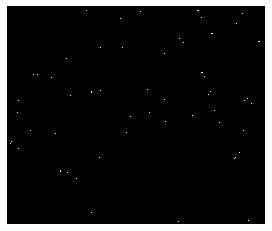

In [18]:
from scipy import ndimage

ret2, thresh2 = cv2.threshold(result,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
bin_img = (1-thresh2/255).astype('bool')
print(cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
filled_int= (bin_img*255).astype('uint8')

cv2.imwrite('spots.jpg',filled_int)
plt.imshow(bin_img, cmap='gray')
plt.axis('off')

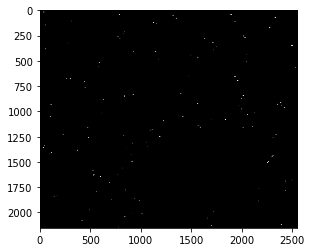

In [92]:
#closed_img = ndimage.binary_closing(~thresh2).astype(np.int)
kernel = np.ones((5,5),np.uint8)

closed_img = cv2.morphologyEx(filled_int, cv2.MORPH_CLOSE, kernel)

blurred_spots = ndimage.gaussian_filter(closed_img, sigma=2)
ret2, thresh2 = cv2.threshold(blurred_spots,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

cv2.imwrite('blurred_spots.jpg',blurred_spots)
plt.imshow(blurred_spots, cmap='gray')

In [93]:
from scipy.ndimage import label
from skimage.feature import peak_local_max
bin_img = (1-thresh2/255).astype('bool')
filled_int= (bin_img*255).astype('uint8')
labeled_array, num_features = label(filled_int)

coordinates = peak_local_max(blurred_spots, labels=labeled_array, num_peaks_per_label=1)

(122, 2) 122 uint8


In [94]:
from skimage import data, color

im = color.gray2rgb(blurred_spots)
im[coordinates[:, 0],coordinates[:, 1]] = (0,0,255)

In [96]:
#plt.imsave('max_points.tif',im)
cv2.imwrite('max_points.tif',im)

True

In [97]:
from skimage.color import label2rgb

rgblabel = label2rgb(labeled_array,alpha=0.1, bg_label = 0)
rgblabel=(rgblabel*255).astype('uint8')
cv2.imwrite('rgblabel.tif',rgblabel)


True

In [105]:
b = np.array(([0,1,1,0],
              [0,1,5,0],
              [0,0,0,0],
              [0,0,3,1],
              [0,0,1,1]))

lbl = ndimage.label(b)[0]
ndimage.measurements.center_of_mass(b, lbl, [1,2])

[(0.75, 1.75), (3.3333333333333335, 2.3333333333333335)]